# Bank Marketing in python using h2o AutoML

More info on H2O AutoML at https://docs.h2o.ai/h2o/latest-stable/h2o-docs/automl.html

Import the required packages

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings

warnings.filterwarnings(action='ignore', category=DeprecationWarning)

In [2]:
from teradataml.dataframe.copy_to import copy_to_sql
from teradataml.context.context import get_connection
from teradataml.dataframe.dataframe import DataFrame
from teradataml import create_context
import getpass
import h2o
from h2o.automl import H2OAutoML

Replace your cluster details for your user, password, host and database.

In [3]:
engine = create_context(host="3.238.151.85", username="AOA_DEMO", password=getpass.getpass("password"))

password ··········


## Exploratory analysis

Load and inspect the dataset

In [4]:
dataset = DataFrame("bank_marketing_data").to_pandas()
# Visualise a table with the first rows of the dataset, to
# better understand the data format
dataset.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,30,unemployed,married,primary,no,1787,no,no,cellular,19,oct,79,1,-1,0,unknown,no
1,33,services,married,secondary,no,4789,yes,yes,cellular,11,may,220,1,339,4,failure,no
2,35,management,single,tertiary,no,1350,yes,no,cellular,16,apr,185,1,330,1,failure,no
3,30,management,married,tertiary,no,1476,yes,yes,unknown,3,jun,199,4,-1,0,unknown,no
4,59,blue-collar,married,secondary,no,0,yes,no,unknown,5,may,226,1,-1,0,unknown,no


Check for correlations

In [5]:
corr = dataset.apply(lambda x : pd.factorize(x)[0]).corr(method='pearson', min_periods=1)
corr

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
age,1.000000,0.166402,-0.007715,-0.045936,-0.007067,0.016128,-0.111345,-0.002402,0.050737,0.023363,0.035760,0.026622,-0.010558,0.036239,0.012112,0.045800,0.065228
job,0.166402,1.000000,-0.012186,-0.088132,-0.002168,-0.015648,-0.160040,0.001375,0.024281,0.005493,0.067786,-0.020892,-0.036376,0.024443,0.022966,0.047513,0.068978
marital,-0.007715,-0.012186,1.000000,0.090907,0.049837,-0.026206,-0.027397,-0.014321,-0.031768,0.025010,-0.009086,0.008537,-0.021882,0.009266,-0.001322,-0.000989,0.061242
education,-0.045936,-0.088132,0.090907,1.000000,-0.010534,0.011534,-0.087070,-0.054086,-0.110384,-0.010523,0.072546,-0.012168,0.005049,0.025968,0.027182,0.045689,0.042987
default,-0.007067,-0.002168,0.049837,-0.010534,1.000000,-0.022277,0.006881,0.063994,-0.006654,0.010775,0.013052,-0.039377,-0.012759,-0.028827,-0.028712,-0.031354,0.001303
balance,0.016128,-0.015648,-0.026206,0.011534,-0.022277,1.000000,0.025923,-0.016647,0.018605,-0.007546,-0.012901,0.139572,-0.022156,0.078316,-0.001406,0.006034,0.031489
housing,-0.111345,-0.160040,-0.027397,-0.087070,0.006881,0.025923,1.000000,0.018451,0.097917,-0.048346,-0.300032,0.020312,-0.010403,0.055139,0.046341,0.006302,-0.104683
loan,-0.002402,0.001375,-0.014321,-0.054086,0.063994,-0.016647,0.018451,1.000000,-0.008376,0.049655,0.083930,-0.011070,0.006911,-0.020633,-0.026135,-0.053685,-0.070517
contact,0.050737,0.024281,-0.031768,-0.110384,-0.006654,0.018605,0.097917,-0.008376,1.000000,-0.004404,-0.250411,0.018738,0.032347,-0.132054,-0.123530,-0.149290,-0.082229
day,0.023363,0.005493,0.025010,-0.010523,0.010775,-0.007546,-0.048346,0.049655,-0.004404,1.000000,0.092859,0.003150,0.049538,-0.028044,-0.028344,-0.018421,0.024205


Lets compare the age of the subscribers

67

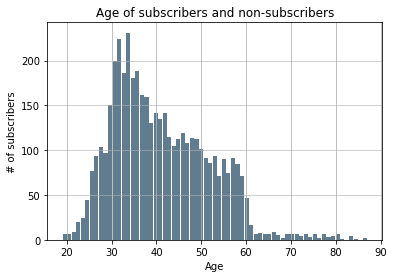

In [6]:
num_bins = dataset['age'].unique().size
dataset['age'].plot.hist(grid=True, bins=num_bins, rwidth=0.9, color='#607c8e')
plt.title('Age of subscribers and non-subscribers')
plt.xlabel('Age')
plt.ylabel('# of subscribers')
plt.grid(axis='y', alpha=0.75)
num_bins

In the histogram above we can see that there is one customer age that is significantly more prevalent than others.

Now we will visualize subscriber percentage by education level, marital status, occupation, and age:

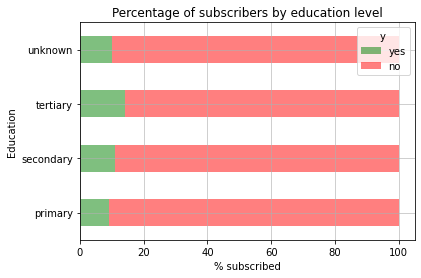

In [7]:
### subscriber % by education level
yn = dataset.groupby(['education', 'y']).size().reset_index(name='counts')
yed = dataset.groupby(['education']).size().reset_index(name='counts')
jed = yn.set_index('education').join(yed.set_index('education'), on='education', how='left', lsuffix='_caller', rsuffix='_other')
jed = jed.assign(perc = (jed['counts_caller']/jed['counts_other']) * 100)
jed = jed.round()
jed = jed.sort_values('y', ascending=True).pivot(columns='y', values='perc')
jed[['yes','no']].plot.barh(stacked=True, color=['Green','Red'], alpha=0.5)
plt.title('Percentage of subscribers by education level')
plt.ylabel('Education')
plt.xlabel('% subscribed')
plt.grid(alpha=0.75)


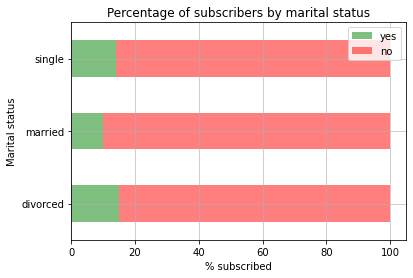

In [8]:
### subscriber % by marital status
yn = dataset.groupby(['marital', 'y']).size().reset_index(name='counts')
yed = dataset.groupby(['marital']).size().reset_index(name='counts')
jed = yn.set_index('marital').join(yed.set_index('marital'), on='marital', how='left', lsuffix='_caller', rsuffix='_other')
jed = jed.assign(perc = (jed['counts_caller']/jed['counts_other']) * 100)
jed = jed.round()
jed = jed.sort_values('y', ascending=True).pivot(columns='y', values='perc')
jed[['yes','no']].plot.barh(stacked=True, color=['Green','Red'], alpha=0.5)
plt.title('Percentage of subscribers by marital status')
plt.ylabel('Marital status')
plt.xlabel('% subscribed')
plt.legend()
plt.grid(alpha=0.75)

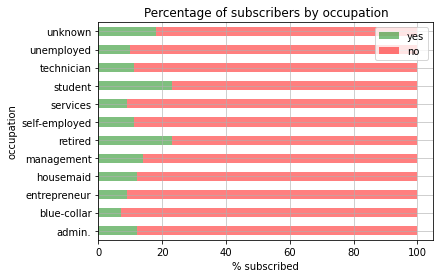

In [9]:
### subscriber by job type
yn = dataset[['job','y']].groupby(['job','y']).size().reset_index(name='counts')
yed = dataset.groupby(['job']).size().reset_index(name='counts')
jed = yn.set_index('job').join(yed.set_index('job'), on='job', how='left', lsuffix='_caller', rsuffix='_other')
jed = jed.assign(perc = (jed['counts_caller']/jed['counts_other']) * 100)
jed = jed.round()
jed = jed.sort_values('y', ascending=True).pivot(columns='y', values='perc')
jed[['yes','no']].plot.barh(stacked=True, color=['Green','Red'], alpha=0.5)
plt.title('Percentage of subscribers by occupation')
plt.ylabel('occupation')
plt.xlabel('% subscribed')
plt.legend()
plt.grid(alpha=0.75)

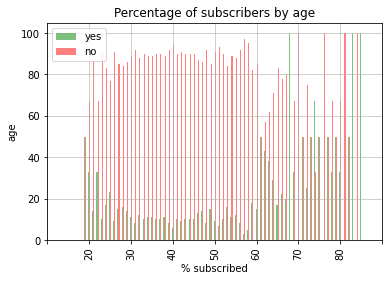

In [10]:
### subscriber by age
yn = dataset[['age','y']].groupby(['age','y']).size().reset_index(name='counts')
yed = dataset.groupby(['age']).size().reset_index(name='counts')
jed = yn.set_index('age').join(yed.set_index('age'), on='age', how='left', lsuffix='_caller', rsuffix='_other')
jed = jed.assign(perc = (jed['counts_caller']/jed['counts_other']) * 100)
jed = jed.round()
jed = jed.sort_values('y', ascending=True).pivot(columns='y', values='perc')
jed[['yes','no']].plot.bar(color=['Green','Red'], alpha=0.5)
plt.title('Percentage of subscribers by age')
plt.ylabel('age')
plt.xlabel('% subscribed')
plt.legend()
plt.xticks([-9,1,11,21,31,41,51,61,71])
plt.grid(alpha=0.75)

## Training 

Upon completing the intial exploratory data analysis, let's run it through AutoML on eight of the columns in the dataset: age, job, marital, education, default, balance, housing, loan.

In [11]:
dataset = DataFrame("bank_marketing_data").select(['age', 'job', 'marital', 'education', 'default', 'balance', 'housing', 'loan', 'y'])
dataset.head()

   age       job marital  education default balance housing loan    y
0   19   student  single    unknown      no       0      no   no   no
1   20   student  single  secondary      no     502      no   no  yes
2   20   student  single  secondary      no     291      no   no   no
3   20   student  single  secondary      no    1191      no   no   no
4   21  services  single  secondary      no     361      no   no   no
5   21  services  single  secondary      no    1903     yes   no   no
6   21   student  single  secondary      no       6      no   no   no
7   19   student  single  secondary      no     302      no   no  yes
8   19   student  single    unknown      no    1169      no   no   no
9   19   student  single    primary      no     103      no   no  yes

Now we must initialize h2o cluster (locally) and prepare the training dataset

In [12]:
h2o.init()
dataset_hf=h2o.H2OFrame(dataset.to_pandas())

Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
  Java Version: openjdk version "1.8.0_292"; OpenJDK Runtime Environment (build 1.8.0_292-8u292-b10-0ubuntu1~20.04-b10); OpenJDK 64-Bit Server VM (build 25.292-b10, mixed mode)
  Starting server from /opt/conda/lib/python3.9/site-packages/h2o/backend/bin/h2o.jar
  Ice root: /tmp/tmpn8v5gvvf
  JVM stdout: /tmp/tmpn8v5gvvf/h2o_unknownUser_started_from_python.out
  JVM stderr: /tmp/tmpn8v5gvvf/h2o_unknownUser_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Etc/UTC
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.34.0.3
H2O_cluster_version_age:,13 days
H2O_cluster_name:,H2O_from_python_unknownUser_138mvz
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,875 Mb
H2O_cluster_total_cores:,6
H2O_cluster_allowed_cores:,6
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%


We split the training dataset

In [13]:
train,test = dataset_hf.split_frame(ratios=[.7])

Identify predictors and response

In [14]:
x = train.columns
y = 'y'
x.remove(y)

For binary classification, response should be a factor

In [15]:
train[y] = train[y].asfactor()
test[y] = test[y].asfactor()

Run AutoML for 20 base models

In [16]:
aml = H2OAutoML(max_models=20, seed=1)
aml.train(x=x, y=y, training_frame=train)

AutoML progress: |███████████████████████████████████████████████████████████████| (done) 100%
Model Details
H2OStackedEnsembleEstimator :  Stacked Ensemble
Model Key:  StackedEnsemble_BestOfFamily_5_AutoML_1_20211020_150929

No model summary for this model

ModelMetricsBinomialGLM: stackedensemble
** Reported on train data. **

MSE: 0.09065082998251246
RMSE: 0.3010827626791551
LogLoss: 0.30663819879088766
Null degrees of freedom: 3146
Residual degrees of freedom: 3141
Null deviance: 2330.6986463526455
Residual deviance: 1929.9808231898476
AIC: 1941.9808231898476
AUC: 0.8433614015333286
AUCPR: 0.48585815140782784
Gini: 0.6867228030666572

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.1862880834647268: 


,,no,yes,Error,Rate
0,no,2478.0,286.0,0.1035,(286.0/2764.0)
1,yes,172.0,211.0,0.4491,(172.0/383.0)
2,Total,2650.0,497.0,0.1455,(458.0/3147.0)



Maximum Metrics: Maximum metrics at their respective thresholds


,metric,threshold,value,idx
0,max f1,0.186288,0.479545,140.0
1,max f2,0.131209,0.586924,217.0
2,max f0point5,0.225797,0.508591,98.0
3,max accuracy,0.272071,0.891961,61.0
4,max precision,0.612714,1.000000,0.0
5,max recall,0.064189,1.000000,335.0
6,max specificity,0.612714,1.000000,0.0
7,max absolute_mcc,0.225797,0.401776,98.0
8,max min_per_class_accuracy,0.142286,0.751809,202.0
9,max mean_per_class_accuracy,0.131209,0.759855,217.0



Gains/Lift Table: Avg response rate: 12.17 %, avg score: 12.46 %


,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,score,cumulative_response_rate,cumulative_score,capture_rate,cumulative_capture_rate,gain,cumulative_gain,kolmogorov_smirnov
0,1,0.010168,0.349388,7.189621,7.189621,0.875000,0.425628,0.875000,0.425628,0.073107,0.073107,618.962141,618.962141,0.071660
1,2,0.020019,0.307426,5.831214,6.521199,0.709677,0.328162,0.793651,0.377669,0.057441,0.130548,483.121368,552.119856,0.125845
2,3,0.030187,0.283746,4.621899,5.881435,0.562500,0.293675,0.715789,0.349376,0.046997,0.177546,362.189948,488.143466,0.167777
3,4,0.040038,0.265419,3.975828,5.412595,0.483871,0.275237,0.658730,0.331136,0.039164,0.216710,297.582751,441.259480,0.201153
4,5,0.050207,0.254129,3.081266,4.940427,0.375000,0.260670,0.601266,0.316864,0.031332,0.248042,208.126632,394.042701,0.225249
5,6,0.100095,0.214770,3.454158,4.199652,0.420382,0.233134,0.511111,0.275132,0.172324,0.420366,245.415842,319.965187,0.364649
6,7,0.149984,0.189903,2.198101,3.533882,0.267516,0.201150,0.430085,0.250524,0.109661,0.530026,119.810081,253.388171,0.432703
7,8,0.200191,0.171754,1.560135,3.038879,0.189873,0.179833,0.369841,0.232795,0.078329,0.608355,56.013484,203.887853,0.464723
8,9,0.299968,0.143606,1.360729,2.480681,0.165605,0.157044,0.301907,0.207598,0.135770,0.744125,36.072907,148.068051,0.505703
9,10,0.400064,0.125647,0.965137,2.101494,0.117460,0.134473,0.255759,0.189302,0.096606,0.840731,-3.486261,110.149379,0.501730




ModelMetricsBinomialGLM: stackedensemble
** Reported on cross-validation data. **

MSE: 0.10378410138802345
RMSE: 0.32215539943949945
LogLoss: 0.35590336904114367
Null degrees of freedom: 3146
Residual degrees of freedom: 3142
Null deviance: 2331.4476726565854
Residual deviance: 2240.055804744958
AIC: 2250.055804744958
AUC: 0.6470387639664013
AUCPR: 0.19837790973847183
Gini: 0.2940775279328025

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.15206398143877353: 


,,no,yes,Error,Rate
0,no,2151.0,613.0,0.2218,(613.0/2764.0)
1,yes,217.0,166.0,0.5666,(217.0/383.0)
2,Total,2368.0,779.0,0.2637,(830.0/3147.0)



Maximum Metrics: Maximum metrics at their respective thresholds


,metric,threshold,value,idx
0,max f1,0.152064,0.285714,174.0
1,max f2,0.080689,0.436017,309.0
2,max f0point5,0.171441,0.254037,143.0
3,max accuracy,0.557818,0.877979,0.0
4,max precision,0.301304,0.333333,32.0
5,max recall,0.035476,1.000000,385.0
6,max specificity,0.557818,0.999638,0.0
7,max absolute_mcc,0.171441,0.163562,143.0
8,max min_per_class_accuracy,0.120673,0.595300,231.0
9,max mean_per_class_accuracy,0.147066,0.606354,182.0



Gains/Lift Table: Avg response rate: 12.17 %, avg score: 12.19 %


,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,score,cumulative_response_rate,cumulative_score,capture_rate,cumulative_capture_rate,gain,cumulative_gain,kolmogorov_smirnov
0,1,0.010168,0.321413,2.054178,2.054178,0.250000,0.380901,0.250000,0.380901,0.020888,0.020888,105.417755,105.417755,0.012205
1,2,0.020019,0.273703,2.915607,2.478055,0.354839,0.290346,0.301587,0.336342,0.028721,0.049608,191.560684,147.805545,0.033689
2,3,0.030187,0.251389,1.797405,2.248784,0.218750,0.261085,0.273684,0.310992,0.018277,0.067885,79.740535,124.878384,0.042921
3,4,0.040038,0.242848,2.385497,2.282419,0.290323,0.247498,0.277778,0.295371,0.023499,0.091384,138.549650,128.241950,0.058461
4,5,0.050207,0.231446,2.824494,2.392207,0.343750,0.236699,0.291139,0.283488,0.028721,0.120104,182.449413,139.220676,0.079583
5,6,0.100095,0.200520,1.674743,2.034614,0.203822,0.214531,0.247619,0.249119,0.083551,0.203655,67.474348,103.461395,0.117910
6,7,0.149984,0.177557,1.831751,1.967136,0.222930,0.188310,0.239407,0.228892,0.091384,0.295039,83.175068,96.713612,0.165155
7,8,0.200191,0.162435,1.508130,1.852020,0.183544,0.169915,0.225397,0.214101,0.075718,0.370757,50.813035,85.202039,0.194201
8,9,0.299968,0.140287,1.072883,1.592858,0.130573,0.151338,0.193856,0.193225,0.107050,0.477807,7.288254,59.285801,0.202481
9,10,0.400064,0.123606,0.991222,1.442330,0.120635,0.131450,0.175536,0.177769,0.099217,0.577023,-0.877782,44.232959,0.201481


View the AutoML Leaderboard

In [17]:
lb = aml.leaderboard
lb.head(rows=lb.nrows)

model_id,auc,logloss,aucpr,mean_per_class_error,rmse,mse
StackedEnsemble_BestOfFamily_5_AutoML_1_20211020_150929,0.647039,0.355903,0.198378,0.39418,0.322155,0.103784
StackedEnsemble_BestOfFamily_8_AutoML_1_20211020_150929,0.644775,0.356544,0.203939,0.399399,0.322137,0.103772
GBM_grid_1_AutoML_1_20211020_150929_model_2,0.637394,0.358593,0.194777,0.400294,0.323297,0.104521
StackedEnsemble_AllModels_7_AutoML_1_20211020_150929,0.636594,0.357664,0.194539,0.405745,0.322593,0.104066
StackedEnsemble_AllModels_3_AutoML_1_20211020_150929,0.636055,0.358316,0.18592,0.411944,0.32316,0.104432
StackedEnsemble_BestOfFamily_4_AutoML_1_20211020_150929,0.635982,0.358132,0.191262,0.402194,0.322905,0.104268
StackedEnsemble_AllModels_4_AutoML_1_20211020_150929,0.635676,0.358116,0.193332,0.397575,0.322711,0.104142
StackedEnsemble_AllModels_1_AutoML_1_20211020_150929,0.633406,0.358196,0.188608,0.407856,0.322839,0.104225
StackedEnsemble_BestOfFamily_3_AutoML_1_20211020_150929,0.633268,0.358141,0.188913,0.407925,0.322905,0.104268
StackedEnsemble_BestOfFamily_2_AutoML_1_20211020_150929,0.63278,0.358211,0.187267,0.401615,0.322872,0.104246


The leader model is stored here

In [18]:
model=aml.leader
model

Model Details
H2OStackedEnsembleEstimator :  Stacked Ensemble
Model Key:  StackedEnsemble_BestOfFamily_5_AutoML_1_20211020_150929

No model summary for this model

ModelMetricsBinomialGLM: stackedensemble
** Reported on train data. **

MSE: 0.09065082998251246
RMSE: 0.3010827626791551
LogLoss: 0.30663819879088766
Null degrees of freedom: 3146
Residual degrees of freedom: 3141
Null deviance: 2330.6986463526455
Residual deviance: 1929.9808231898476
AIC: 1941.9808231898476
AUC: 0.8433614015333286
AUCPR: 0.48585815140782784
Gini: 0.6867228030666572

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.1862880834647268: 


,,no,yes,Error,Rate
0,no,2478.0,286.0,0.1035,(286.0/2764.0)
1,yes,172.0,211.0,0.4491,(172.0/383.0)
2,Total,2650.0,497.0,0.1455,(458.0/3147.0)



Maximum Metrics: Maximum metrics at their respective thresholds


,metric,threshold,value,idx
0,max f1,0.186288,0.479545,140.0
1,max f2,0.131209,0.586924,217.0
2,max f0point5,0.225797,0.508591,98.0
3,max accuracy,0.272071,0.891961,61.0
4,max precision,0.612714,1.000000,0.0
5,max recall,0.064189,1.000000,335.0
6,max specificity,0.612714,1.000000,0.0
7,max absolute_mcc,0.225797,0.401776,98.0
8,max min_per_class_accuracy,0.142286,0.751809,202.0
9,max mean_per_class_accuracy,0.131209,0.759855,217.0



Gains/Lift Table: Avg response rate: 12.17 %, avg score: 12.46 %


,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,score,cumulative_response_rate,cumulative_score,capture_rate,cumulative_capture_rate,gain,cumulative_gain,kolmogorov_smirnov
0,1,0.010168,0.349388,7.189621,7.189621,0.875000,0.425628,0.875000,0.425628,0.073107,0.073107,618.962141,618.962141,0.071660
1,2,0.020019,0.307426,5.831214,6.521199,0.709677,0.328162,0.793651,0.377669,0.057441,0.130548,483.121368,552.119856,0.125845
2,3,0.030187,0.283746,4.621899,5.881435,0.562500,0.293675,0.715789,0.349376,0.046997,0.177546,362.189948,488.143466,0.167777
3,4,0.040038,0.265419,3.975828,5.412595,0.483871,0.275237,0.658730,0.331136,0.039164,0.216710,297.582751,441.259480,0.201153
4,5,0.050207,0.254129,3.081266,4.940427,0.375000,0.260670,0.601266,0.316864,0.031332,0.248042,208.126632,394.042701,0.225249
5,6,0.100095,0.214770,3.454158,4.199652,0.420382,0.233134,0.511111,0.275132,0.172324,0.420366,245.415842,319.965187,0.364649
6,7,0.149984,0.189903,2.198101,3.533882,0.267516,0.201150,0.430085,0.250524,0.109661,0.530026,119.810081,253.388171,0.432703
7,8,0.200191,0.171754,1.560135,3.038879,0.189873,0.179833,0.369841,0.232795,0.078329,0.608355,56.013484,203.887853,0.464723
8,9,0.299968,0.143606,1.360729,2.480681,0.165605,0.157044,0.301907,0.207598,0.135770,0.744125,36.072907,148.068051,0.505703
9,10,0.400064,0.125647,0.965137,2.101494,0.117460,0.134473,0.255759,0.189302,0.096606,0.840731,-3.486261,110.149379,0.501730




ModelMetricsBinomialGLM: stackedensemble
** Reported on cross-validation data. **

MSE: 0.10378410138802345
RMSE: 0.32215539943949945
LogLoss: 0.35590336904114367
Null degrees of freedom: 3146
Residual degrees of freedom: 3142
Null deviance: 2331.4476726565854
Residual deviance: 2240.055804744958
AIC: 2250.055804744958
AUC: 0.6470387639664013
AUCPR: 0.19837790973847183
Gini: 0.2940775279328025

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.15206398143877353: 


,,no,yes,Error,Rate
0,no,2151.0,613.0,0.2218,(613.0/2764.0)
1,yes,217.0,166.0,0.5666,(217.0/383.0)
2,Total,2368.0,779.0,0.2637,(830.0/3147.0)



Maximum Metrics: Maximum metrics at their respective thresholds


,metric,threshold,value,idx
0,max f1,0.152064,0.285714,174.0
1,max f2,0.080689,0.436017,309.0
2,max f0point5,0.171441,0.254037,143.0
3,max accuracy,0.557818,0.877979,0.0
4,max precision,0.301304,0.333333,32.0
5,max recall,0.035476,1.000000,385.0
6,max specificity,0.557818,0.999638,0.0
7,max absolute_mcc,0.171441,0.163562,143.0
8,max min_per_class_accuracy,0.120673,0.595300,231.0
9,max mean_per_class_accuracy,0.147066,0.606354,182.0



Gains/Lift Table: Avg response rate: 12.17 %, avg score: 12.19 %


,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,score,cumulative_response_rate,cumulative_score,capture_rate,cumulative_capture_rate,gain,cumulative_gain,kolmogorov_smirnov
0,1,0.010168,0.321413,2.054178,2.054178,0.250000,0.380901,0.250000,0.380901,0.020888,0.020888,105.417755,105.417755,0.012205
1,2,0.020019,0.273703,2.915607,2.478055,0.354839,0.290346,0.301587,0.336342,0.028721,0.049608,191.560684,147.805545,0.033689
2,3,0.030187,0.251389,1.797405,2.248784,0.218750,0.261085,0.273684,0.310992,0.018277,0.067885,79.740535,124.878384,0.042921
3,4,0.040038,0.242848,2.385497,2.282419,0.290323,0.247498,0.277778,0.295371,0.023499,0.091384,138.549650,128.241950,0.058461
4,5,0.050207,0.231446,2.824494,2.392207,0.343750,0.236699,0.291139,0.283488,0.028721,0.120104,182.449413,139.220676,0.079583
5,6,0.100095,0.200520,1.674743,2.034614,0.203822,0.214531,0.247619,0.249119,0.083551,0.203655,67.474348,103.461395,0.117910
6,7,0.149984,0.177557,1.831751,1.967136,0.222930,0.188310,0.239407,0.228892,0.091384,0.295039,83.175068,96.713612,0.165155
7,8,0.200191,0.162435,1.508130,1.852020,0.183544,0.169915,0.225397,0.214101,0.075718,0.370757,50.813035,85.202039,0.194201
8,9,0.299968,0.140287,1.072883,1.592858,0.130573,0.151338,0.193856,0.193225,0.107050,0.477807,7.288254,59.285801,0.202481
9,10,0.400064,0.123606,0.991222,1.442330,0.120635,0.131450,0.175536,0.177769,0.099217,0.577023,-0.877782,44.232959,0.201481


## Evaluation

Now we evaluate the predictions against the test dataframe.

In [19]:
preds=model.predict(test)
preds.head()

stackedensemble prediction progress: |███████████████████████████████████████████| (done) 100%


predict,no,yes
no,0.899056,0.100944
no,0.888161,0.111839
no,0.922157,0.0778432
yes,0.81804,0.18196
yes,0.807677,0.192323
no,0.905215,0.0947847
yes,0.837212,0.162788
no,0.870077,0.129923
yes,0.68643,0.31357
no,0.884203,0.115797


Evaluate performance

In [20]:
perf=model.model_performance()
perf


ModelMetricsBinomialGLM: stackedensemble
** Reported on train data. **

MSE: 0.09065082998251246
RMSE: 0.3010827626791551
LogLoss: 0.30663819879088766
Null degrees of freedom: 3146
Residual degrees of freedom: 3141
Null deviance: 2330.6986463526455
Residual deviance: 1929.9808231898476
AIC: 1941.9808231898476
AUC: 0.8433614015333286
AUCPR: 0.48585815140782784
Gini: 0.6867228030666572

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.1862880834647268: 


,,no,yes,Error,Rate
0,no,2478.0,286.0,0.1035,(286.0/2764.0)
1,yes,172.0,211.0,0.4491,(172.0/383.0)
2,Total,2650.0,497.0,0.1455,(458.0/3147.0)



Maximum Metrics: Maximum metrics at their respective thresholds


,metric,threshold,value,idx
0,max f1,0.186288,0.479545,140.0
1,max f2,0.131209,0.586924,217.0
2,max f0point5,0.225797,0.508591,98.0
3,max accuracy,0.272071,0.891961,61.0
4,max precision,0.612714,1.000000,0.0
5,max recall,0.064189,1.000000,335.0
6,max specificity,0.612714,1.000000,0.0
7,max absolute_mcc,0.225797,0.401776,98.0
8,max min_per_class_accuracy,0.142286,0.751809,202.0
9,max mean_per_class_accuracy,0.131209,0.759855,217.0



Gains/Lift Table: Avg response rate: 12.17 %, avg score: 12.46 %


,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,score,cumulative_response_rate,cumulative_score,capture_rate,cumulative_capture_rate,gain,cumulative_gain,kolmogorov_smirnov
0,1,0.010168,0.349388,7.189621,7.189621,0.875000,0.425628,0.875000,0.425628,0.073107,0.073107,618.962141,618.962141,0.071660
1,2,0.020019,0.307426,5.831214,6.521199,0.709677,0.328162,0.793651,0.377669,0.057441,0.130548,483.121368,552.119856,0.125845
2,3,0.030187,0.283746,4.621899,5.881435,0.562500,0.293675,0.715789,0.349376,0.046997,0.177546,362.189948,488.143466,0.167777
3,4,0.040038,0.265419,3.975828,5.412595,0.483871,0.275237,0.658730,0.331136,0.039164,0.216710,297.582751,441.259480,0.201153
4,5,0.050207,0.254129,3.081266,4.940427,0.375000,0.260670,0.601266,0.316864,0.031332,0.248042,208.126632,394.042701,0.225249
5,6,0.100095,0.214770,3.454158,4.199652,0.420382,0.233134,0.511111,0.275132,0.172324,0.420366,245.415842,319.965187,0.364649
6,7,0.149984,0.189903,2.198101,3.533882,0.267516,0.201150,0.430085,0.250524,0.109661,0.530026,119.810081,253.388171,0.432703
7,8,0.200191,0.171754,1.560135,3.038879,0.189873,0.179833,0.369841,0.232795,0.078329,0.608355,56.013484,203.887853,0.464723
8,9,0.299968,0.143606,1.360729,2.480681,0.165605,0.157044,0.301907,0.207598,0.135770,0.744125,36.072907,148.068051,0.505703
9,10,0.400064,0.125647,0.965137,2.101494,0.117460,0.134473,0.255759,0.189302,0.096606,0.840731,-3.486261,110.149379,0.501730


Explain the model

# Confusion Matrix

> Confusion matrix shows a predicted class vs an actual class.

## StackedEnsemble_BestOfFamily_5_AutoML_1_20211020_150929


Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.19007832837561747: 


,,no,yes,Error,Rate
0,no,1098.0,138.0,0.1117,(138.0/1236.0)
1,yes,96.0,42.0,0.6957,(96.0/138.0)
2,Total,1194.0,180.0,0.1703,(234.0/1374.0)


# Partial Dependence Plots

> Partial dependence plot (PDP) gives a graphical depiction of the marginal effect of a variable on the response. The effect of a variable is measured in change in the mean response. PDP assumes independence between the feature for which is the PDP computed and the rest.

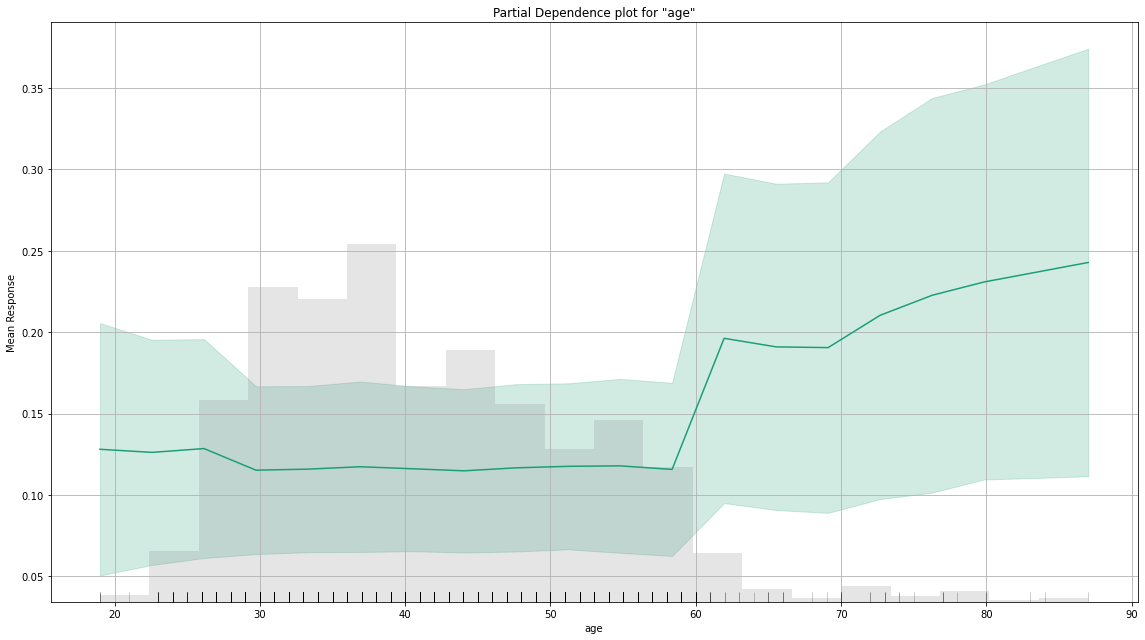

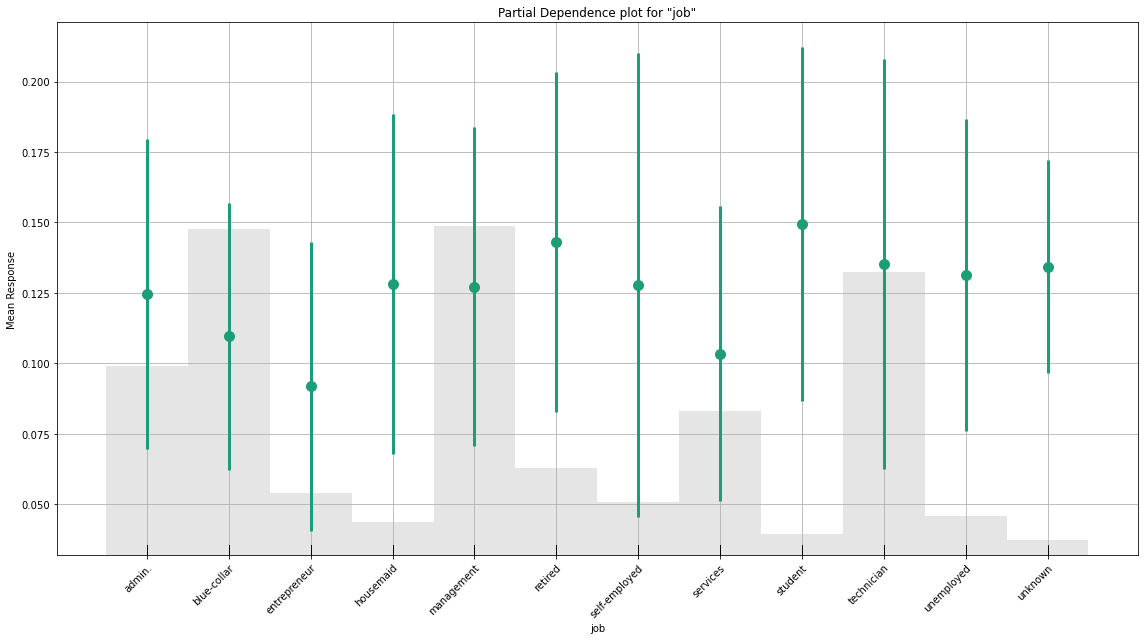

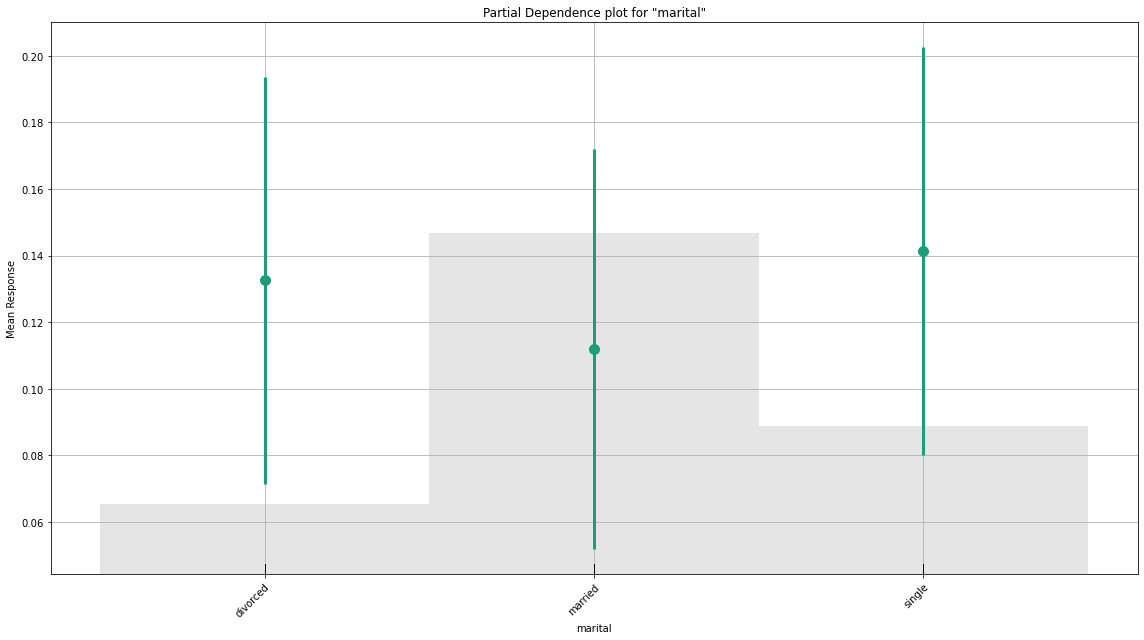

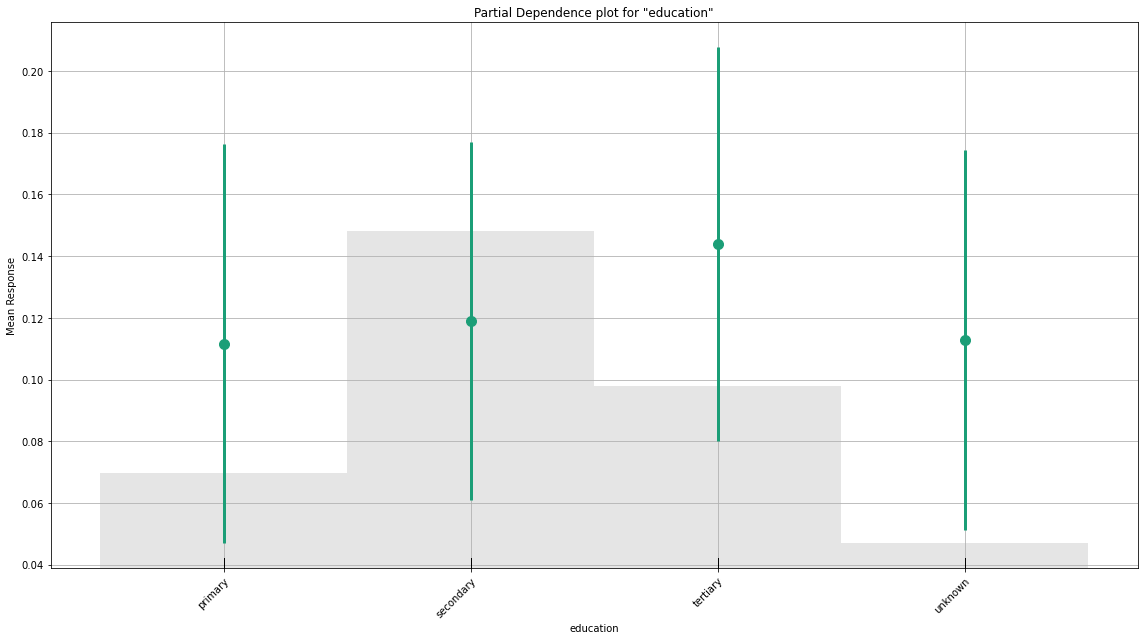

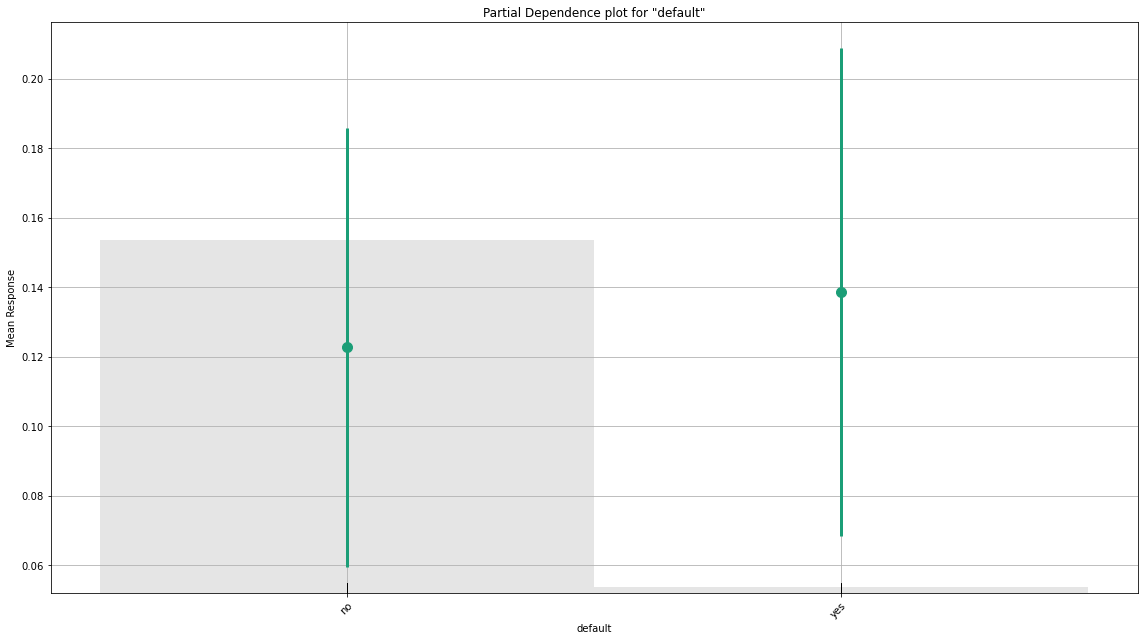

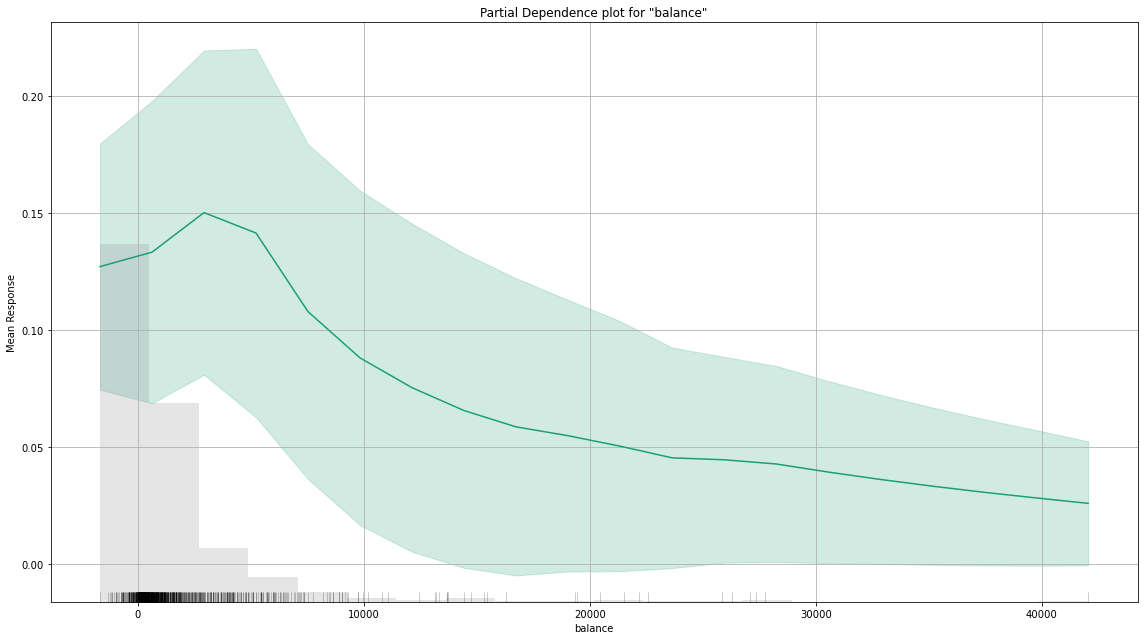

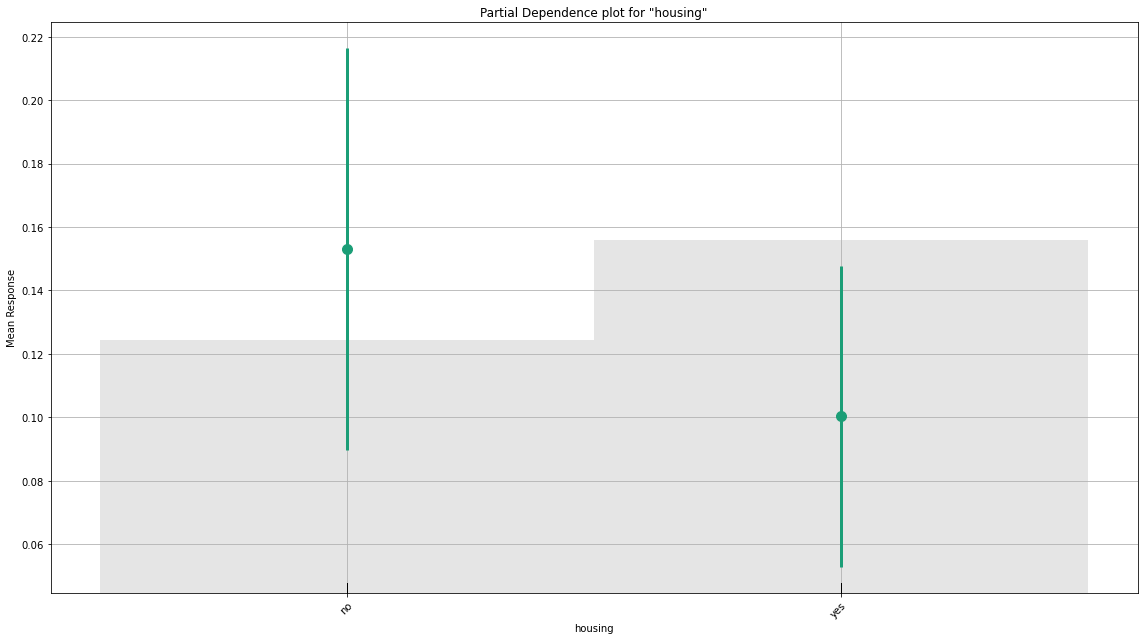

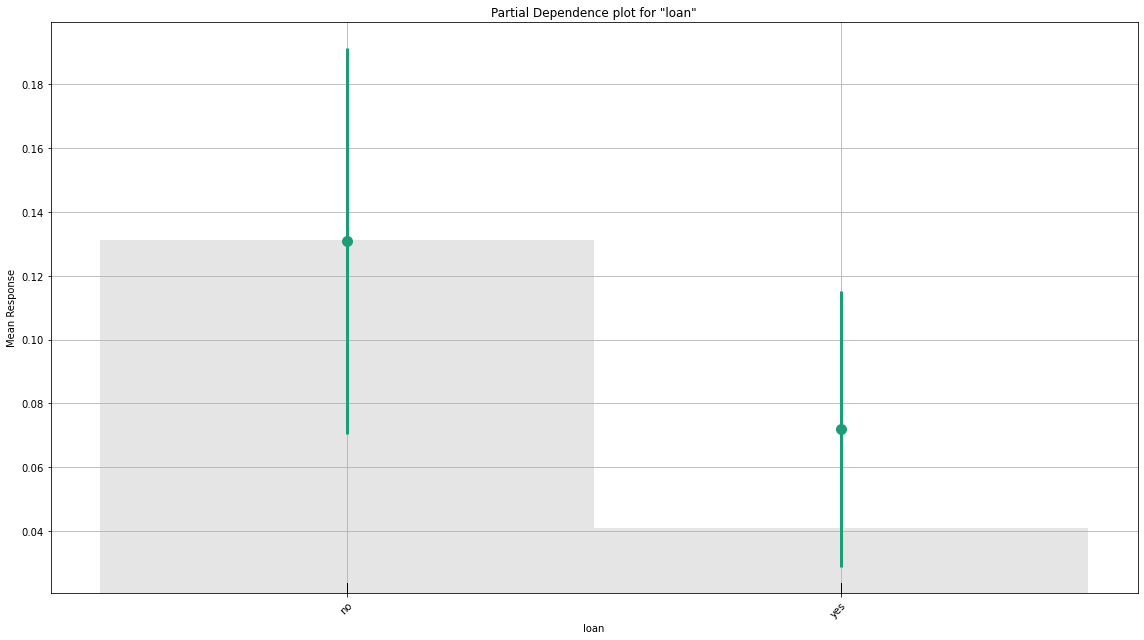

In [22]:
exm=model.explain(test)

Get the variable importance plot

In [23]:
gbm = aml.get_best_model(algorithm="gbm")
fi = gbm.varimp(True)
fix = fi[['variable','scaled_importance']]
fis = fix.to_dict('records')
feature_importance = {v['variable']:v['scaled_importance'] for (k,v) in enumerate(fis)}
feature_importance

{'job': 1.0,
 'balance': 0.81108333559575,
 'age': 0.7443911210239768,
 'housing': 0.30262398565418996,
 'education': 0.22438954777423448,
 'marital': 0.16035779597456903,
 'loan': 0.13488315836150913,
 'default': 0.00465984957017564}

In [25]:
gbm.varimp(True)

,variable,relative_importance,scaled_importance,percentage
0,job,54.798775,1.000000,0.295649
1,balance,44.446373,0.811083,0.239796
2,age,40.791721,0.744391,0.220079
3,housing,16.583424,0.302624,0.089470
4,education,12.296272,0.224390,0.066341
5,marital,8.787411,0.160358,0.047410
6,loan,7.391432,0.134883,0.039878
7,default,0.255354,0.004660,0.001378


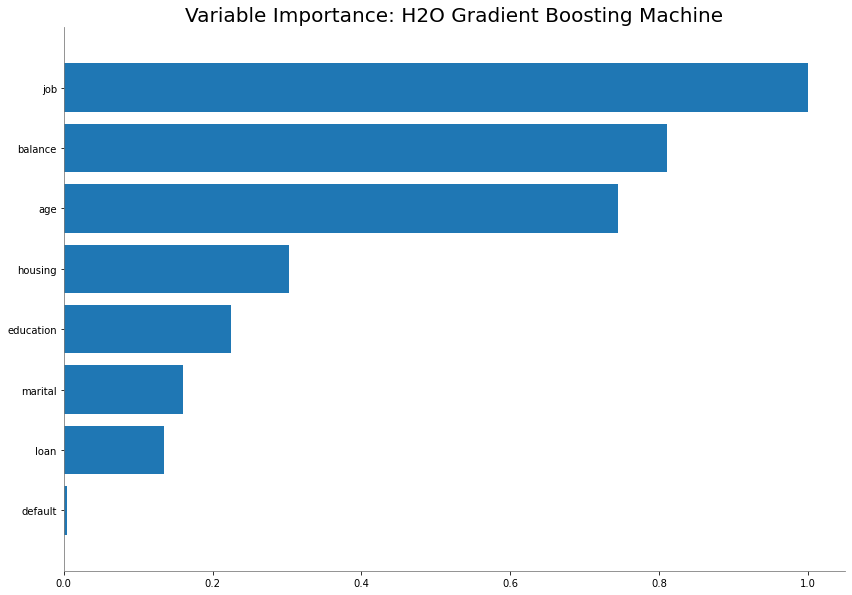

In [26]:
ra_plot = gbm.varimp_plot()

Extract feature interactions:

In [27]:
feature_interactions=gbm.feature_interaction()
feature_interactions


Interaction Depth 0: 


,,interaction,gain,fscore,wfscore,average_wfscore,average_gain,expected_gain,gain_rank,fscore_rank,wfscore_rank,avg_wfscore_rank,avg_gain_rank,expected_gain_rank,average_rank,average_tree_index,average_tree_depth
0,,education,26.271820,29.0,6.393073,0.220451,0.905925,9.665664,7.0,4.0,6.0,6.0,7.0,7.0,6.166667,8.551724,2.379310
1,,balance,190.090013,81.0,21.612011,0.266815,2.346790,106.427189,1.0,1.0,1.0,5.0,5.0,1.0,2.333333,11.604938,2.271605
2,,housing,113.810951,16.0,9.843978,0.615249,7.113184,95.299163,4.0,5.0,4.0,2.0,2.0,3.0,3.333333,9.562500,1.562500
3,,default,0.255354,1.0,0.058151,0.058151,0.255354,0.014849,8.0,8.0,8.0,8.0,8.0,8.0,8.000000,6.000000,3.000000
4,,job,146.002897,81.0,13.267239,0.163793,1.802505,64.845092,3.0,2.0,3.0,7.0,6.0,6.0,4.500000,10.518519,2.407407
5,,loan,100.675987,12.0,7.646330,0.637194,8.389666,76.523528,5.0,7.0,5.0,1.0,1.0,4.0,3.833333,11.000000,1.250000
6,,marital,97.701358,16.0,5.164919,0.322807,6.106335,76.192276,6.0,6.0,7.0,3.0,3.0,5.0,5.000000,10.812500,2.062500
7,,age,163.918020,61.0,19.609152,0.321462,2.687181,99.339297,2.0,3.0,2.0,4.0,4.0,2.0,2.833333,9.868852,2.114754



Interaction Depth 1: 


,,interaction,gain,fscore,wfscore,average_wfscore,average_gain,expected_gain,gain_rank,fscore_rank,wfscore_rank,avg_wfscore_rank,avg_gain_rank,expected_gain_rank,average_rank,average_tree_index,average_tree_depth
0,,housing|loan,107.788166,4.0,2.394979,0.598745,26.947042,70.095696,8.0,18.0,15.0,1.0,2.0,3.0,7.833333,7.500000,1.500000
1,,housing|job,71.470830,6.0,1.937083,0.322847,11.911805,34.544957,17.0,15.0,17.0,9.0,8.0,12.0,13.000000,12.666667,2.333333
2,,housing|marital,67.880600,2.0,0.840483,0.420242,33.940300,28.463819,19.0,21.0,19.0,6.0,1.0,16.0,13.666667,2.500000,2.000000
3,,age|housing,225.046998,12.0,5.976168,0.498014,18.753917,135.030071,2.0,10.0,2.0,3.0,5.0,1.0,3.833333,9.750000,1.833333
4,,balance|housing,125.972334,11.0,4.452812,0.404801,11.452030,55.207687,7.0,12.0,3.0,7.0,10.0,10.0,8.166667,9.727273,2.272727
5,,age|age,87.482692,8.0,2.888783,0.361098,10.935337,63.960194,15.0,13.0,10.0,8.0,11.0,5.0,10.333333,12.500000,1.875000
6,,job|marital,126.970168,13.0,3.101684,0.238591,9.766936,49.007841,6.0,7.0,9.0,11.0,12.0,11.0,9.333333,9.538462,2.615385
7,,education|housing,1.931908,2.0,0.196060,0.098030,0.965954,0.270637,24.0,22.0,22.0,22.0,24.0,24.0,23.000000,8.500000,3.000000
8,,education|job,103.015029,18.0,3.354306,0.186350,5.723057,28.043915,10.0,3.0,6.0,16.0,17.0,18.0,11.666667,9.111111,2.722222
9,,age|education,80.388470,13.0,1.652050,0.127081,6.183728,17.406879,16.0,8.0,18.0,19.0,15.0,19.0,15.833333,7.538462,2.692308



See the whole table with table.as_data_frame()

Interaction Depth 2: 


,,interaction,gain,fscore,wfscore,average_wfscore,average_gain,expected_gain,gain_rank,fscore_rank,wfscore_rank,avg_wfscore_rank,avg_gain_rank,expected_gain_rank,average_rank,average_tree_index,average_tree_depth
0,,education|job|job,39.074168,2.0,0.270416,0.135208,19.537084,8.597735,34.0,35.0,34.0,30.0,27.0,30.0,31.666667,16.500000,3.000000
1,,age|education|job,98.359738,7.0,0.938354,0.134051,14.051391,13.989950,14.0,12.0,18.0,31.0,37.0,25.0,22.833333,9.857143,3.000000
2,,balance|balance|job,221.998755,13.0,1.906578,0.146660,17.076827,37.385355,3.0,2.0,5.0,29.0,33.0,10.0,13.666667,15.615385,2.923077
3,,age|age|education,35.497548,2.0,0.006991,0.003495,17.748774,0.124078,36.0,36.0,49.0,49.0,31.0,49.0,41.666667,8.000000,3.000000
4,,age|age|marital,27.283193,1.0,0.038132,0.038132,27.283193,1.040351,42.0,42.0,47.0,44.0,11.0,46.0,38.666667,21.000000,2.000000
5,,age|education|housing,60.018611,3.0,0.507785,0.169262,20.006204,10.774940,27.0,24.0,28.0,24.0,24.0,27.0,25.666667,2.666667,2.000000
6,,age|balance|housing,196.356223,8.0,2.597712,0.324714,24.544528,66.551898,5.0,6.0,2.0,8.0,16.0,2.0,6.500000,8.750000,2.500000
7,,age|housing|marital,103.239241,3.0,0.995551,0.331850,34.413080,33.946825,13.0,25.0,17.0,7.0,3.0,11.0,12.666667,3.000000,2.333333
8,,education|job|loan,70.108629,4.0,0.610423,0.152606,17.527157,16.511539,23.0,20.0,25.0,27.0,32.0,22.0,24.833333,13.000000,2.500000
9,,age|age|balance,34.839800,3.0,0.214808,0.071603,11.613267,3.775011,37.0,26.0,37.0,38.0,40.0,35.0,35.500000,8.000000,2.666667



See the whole table with table.as_data_frame()

Interaction Depth 3: 


,,interaction,gain,fscore,wfscore,average_wfscore,average_gain,expected_gain,gain_rank,fscore_rank,wfscore_rank,avg_wfscore_rank,avg_gain_rank,expected_gain_rank,average_rank,average_tree_index,average_tree_depth
0,,age|job|job|marital,4.890731,1.0,0.028281,0.028281,4.890731,0.138314,58.0,39.0,52.0,50.0,55.0,55.0,51.500000,14.000000,3.0
1,,age|balance|balance|loan,28.654970,1.0,0.673340,0.673340,28.654970,19.294529,38.0,40.0,11.0,1.0,10.0,8.0,18.000000,7.000000,3.0
2,,age|balance|housing|marital,33.970260,1.0,0.178901,0.178901,33.970260,6.077298,34.0,41.0,33.0,20.0,6.0,26.0,26.666667,1.000000,3.0
3,,age|age|housing|loan,52.510978,2.0,0.653638,0.326819,26.255489,16.752951,20.0,21.0,13.0,5.0,17.0,11.0,14.500000,10.000000,3.0
4,,balance|job|job|marital,12.566913,1.0,0.115348,0.115348,12.566913,1.449568,52.0,42.0,40.0,33.0,47.0,42.0,42.666667,9.000000,3.0
5,,age|balance|education|marital,17.065865,2.0,0.268192,0.134096,8.532932,3.296898,48.0,22.0,26.0,27.0,50.0,33.0,34.333333,5.000000,3.0
6,,balance|education|job|loan,103.323734,4.0,0.590086,0.147521,25.830934,17.841167,7.0,8.0,16.0,26.0,18.0,9.0,14.000000,13.000000,3.0
7,,age|housing|job|loan,114.847010,4.0,0.772799,0.193200,28.711753,22.179523,4.0,9.0,6.0,16.0,9.0,5.0,8.166667,10.250000,3.0
8,,age|age|balance|education,14.112283,2.0,0.022243,0.011122,7.056141,0.185844,51.0,23.0,55.0,58.0,52.0,53.0,48.666667,10.000000,3.0
9,,age|balance|balance|housing,69.758683,3.0,0.466476,0.155492,23.252894,11.438345,12.0,14.0,19.0,23.0,20.0,18.0,17.666667,4.666667,3.0



See the whole table with table.as_data_frame()

Leaf Statistics: 


,,interaction,sum_leaf_values_left,sum_leaf_values_right,sum_leaf_covers_left,sum_leaf_covers_right
0,,age|job|job|marital,-0.000684,0.057621,20.0,69.0
1,,age|balance|balance|loan,-0.000575,0.064729,1800.0,319.0
2,,age|balance|housing|marital,0.151526,-0.006732,14.0,549.0
3,,age|age|housing|loan,-0.043739,0.055372,995.0,1062.0
4,,balance|job|job|marital,-0.030037,0.030154,104.0,259.0
5,,age|balance|education|marital,0.005786,0.414108,833.0,11.0
6,,balance|education|job|loan,-0.110812,0.073550,346.0,1511.0
7,,age|housing|job|loan,0.173446,0.166150,1661.0,771.0
8,,age|age|balance|education,0.304475,0.067695,27.0,43.0
9,,age|education|housing,0.073249,0.634565,5.0,5.0



See the whole table with table.as_data_frame()

education Split Value Histogram: 


,,split_value,count
0,,NaN,29



balance Split Value Histogram: 


,,split_value,count
0,,-778.0,1
1,,-775.5,1
2,,-753.5,1
3,,-693.5,1
4,,-415.5,1
5,,-402.5,3
6,,-399.5,1
7,,-364.0,1
8,,-356.5,1
9,,-257.5,1



See the whole table with table.as_data_frame()

housing Split Value Histogram: 


,,split_value,count
0,,NaN,16



default Split Value Histogram: 


,,split_value,count
0,,NaN,1



job Split Value Histogram: 


,,split_value,count
0,,NaN,81



loan Split Value Histogram: 


,,split_value,count
0,,NaN,12



marital Split Value Histogram: 


,,split_value,count
0,,NaN,16



age Split Value Histogram: 


,,split_value,count
0,,22.5,1
1,,23.0,1
2,,25.5,1
3,,29.5,5
4,,31.0,2
5,,36.0,1
6,,36.5,1
7,,42.5,1
8,,45.5,1
9,,46.5,1



See the whole table with table.as_data_frame()


[, , , , , , , , , , , , ]

Get the variable importance heatmap

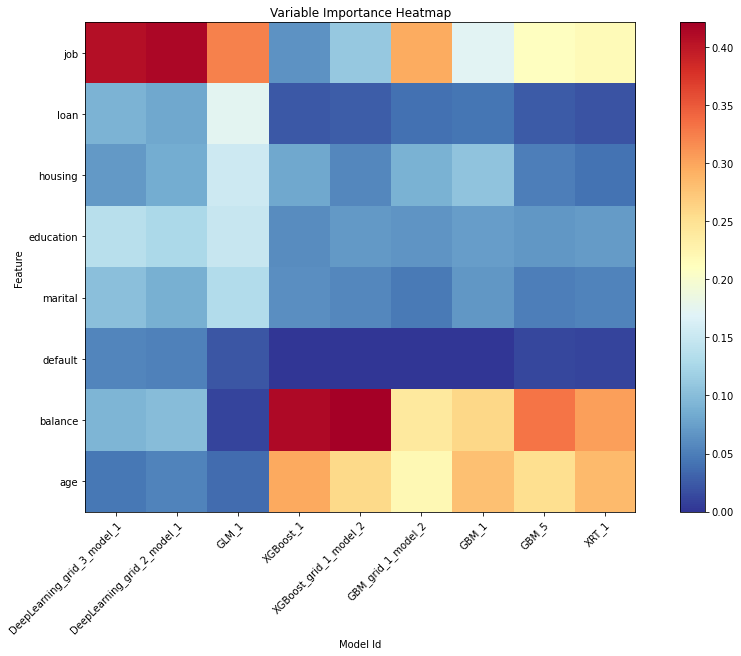

In [28]:
va_plot = aml.varimp_heatmap()

Get the model correlation heatmap

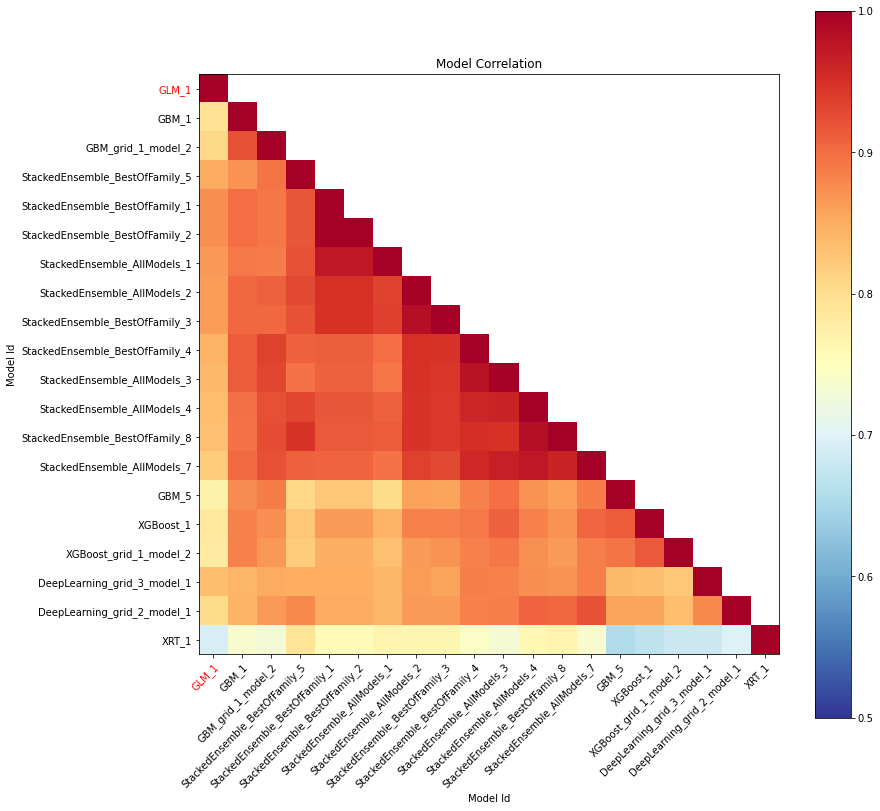

In [29]:
mc_plot = aml.model_correlation_heatmap(test)

Get the shap summary plot

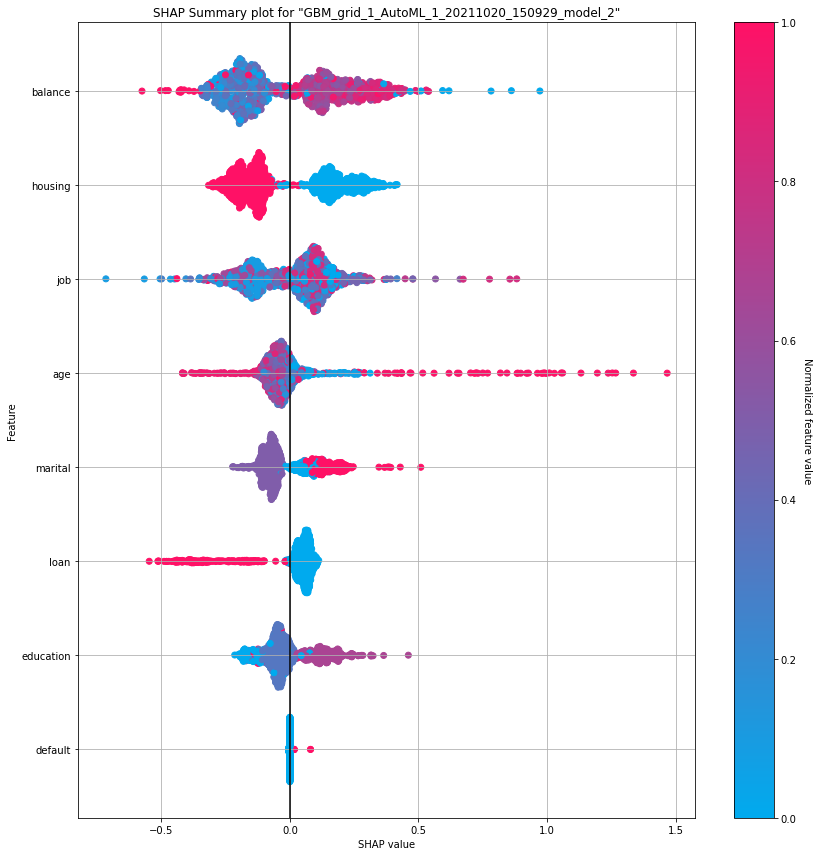

In [31]:
shap_plot = gbm.shap_summary_plot(test)

Get the SHAP local explanation

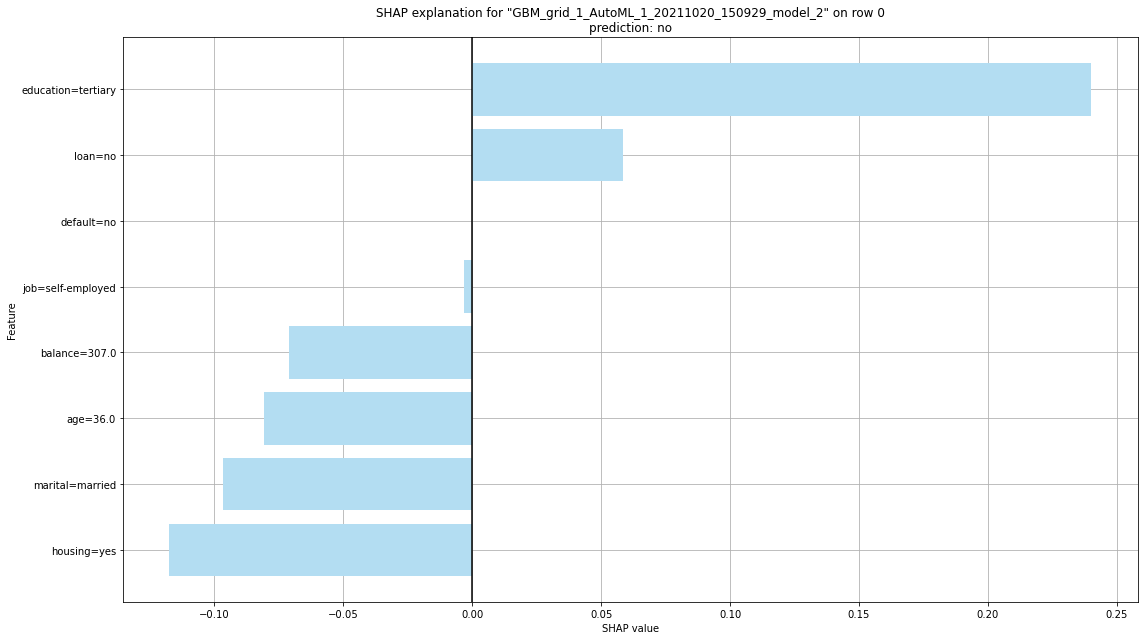

In [32]:
shapr_plot = gbm.shap_explain_row_plot(test, row_index=0)

Now lets get the model metrics based on the evaluation

In [33]:
eval_metrics=model.model_performance(test)
eval_metrics.show()


ModelMetricsBinomialGLM: stackedensemble
** Reported on test data. **

MSE: 0.08764873727048904
RMSE: 0.29605529427876986
LogLoss: 0.31490964401702426
Null degrees of freedom: 1373
Residual degrees of freedom: 1368
Null deviance: 902.0960950770618
Residual deviance: 865.3717017587825
AIC: 877.3717017587825
AUC: 0.6427759016931663
AUCPR: 0.2056193199980652
Gini: 0.2855518033863327

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.19007832837561747: 


,,no,yes,Error,Rate
0,no,1098.0,138.0,0.1117,(138.0/1236.0)
1,yes,96.0,42.0,0.6957,(96.0/138.0)
2,Total,1194.0,180.0,0.1703,(234.0/1374.0)



Maximum Metrics: Maximum metrics at their respective thresholds


,metric,threshold,value,idx
0,max f1,0.190078,0.264151,100.0
1,max f2,0.068433,0.382803,321.0
2,max f0point5,0.260756,0.292398,38.0
3,max accuracy,0.446290,0.900291,0.0
4,max precision,0.446290,1.000000,0.0
5,max recall,0.008605,1.000000,399.0
6,max specificity,0.446290,1.000000,0.0
7,max absolute_mcc,0.260756,0.190550,38.0
8,max min_per_class_accuracy,0.125052,0.594203,203.0
9,max mean_per_class_accuracy,0.143458,0.609663,168.0



Gains/Lift Table: Avg response rate: 10.04 %, avg score: 12.27 %


,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,score,cumulative_response_rate,cumulative_score,capture_rate,cumulative_capture_rate,gain,cumulative_gain,kolmogorov_smirnov
0,1,0.010189,0.321895,3.555901,3.555901,0.357143,0.376434,0.357143,0.376434,0.036232,0.036232,255.590062,255.590062,0.028950
1,2,0.020378,0.294861,4.978261,4.267081,0.500000,0.301615,0.428571,0.339024,0.050725,0.086957,397.826087,326.708075,0.074012
2,3,0.030568,0.273481,2.844720,3.792961,0.285714,0.283929,0.380952,0.320659,0.028986,0.115942,184.472050,279.296066,0.094906
3,4,0.040029,0.253429,3.829431,3.801581,0.384615,0.262003,0.381818,0.306795,0.036232,0.152174,282.943144,280.158103,0.124666
4,5,0.050218,0.242635,0.711180,3.174543,0.071429,0.246878,0.318841,0.294638,0.007246,0.159420,-28.881988,217.454316,0.121394
5,6,0.100437,0.203536,1.731569,2.453056,0.173913,0.223172,0.246377,0.258905,0.086957,0.246377,73.156900,145.305608,0.162234
6,7,0.149927,0.181332,1.317775,2.078303,0.132353,0.191996,0.208738,0.236818,0.065217,0.311594,31.777494,107.830308,0.179717
7,8,0.200146,0.166309,1.010082,1.810277,0.101449,0.173914,0.181818,0.221035,0.050725,0.362319,1.008192,81.027668,0.180280
8,9,0.299854,0.141546,1.308156,1.643309,0.131387,0.152286,0.165049,0.198174,0.130435,0.492754,30.815614,64.330941,0.214436
9,10,0.400291,0.126408,0.865784,1.448221,0.086957,0.133478,0.145455,0.181941,0.086957,0.579710,-13.421550,44.822134,0.199451


Get the confusion matrix

In [85]:
confusion = eval_metrics.confusion_matrix()
confusion
from sklearn.metrics import confusion_matrix
tested = test.as_data_frame()['y'].values
predictions = preds.as_data_frame()['predict'].values
cm = confusion_matrix(tested, predictions)
tested
labels = ['no', 'yes']
values = [0,1]

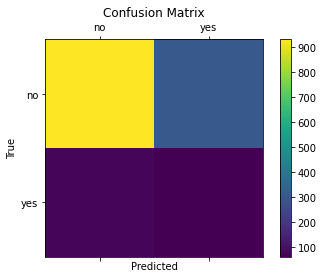

In [86]:
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(cm)
plt.title('Confusion Matrix')
fig.colorbar(cax)
ax.set_xticks(values)
ax.set_xticklabels(labels)
ax.set_yticks(values)
ax.set_yticklabels(labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

Get the ROC curve plot

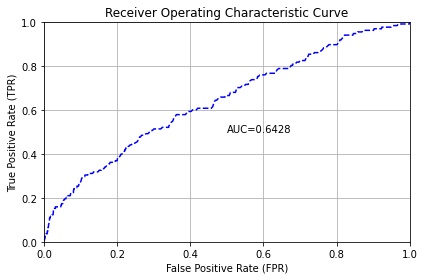

In [35]:
eval_metrics.plot(type = "roc")

Get the precision recall curve plot

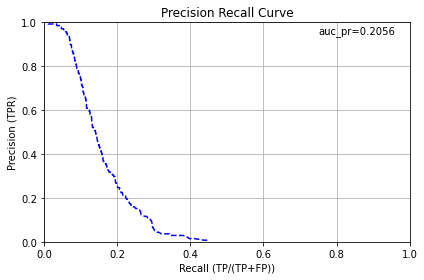

In [36]:
eval_metrics.plot(type = "pr")

Get the learning curve plot

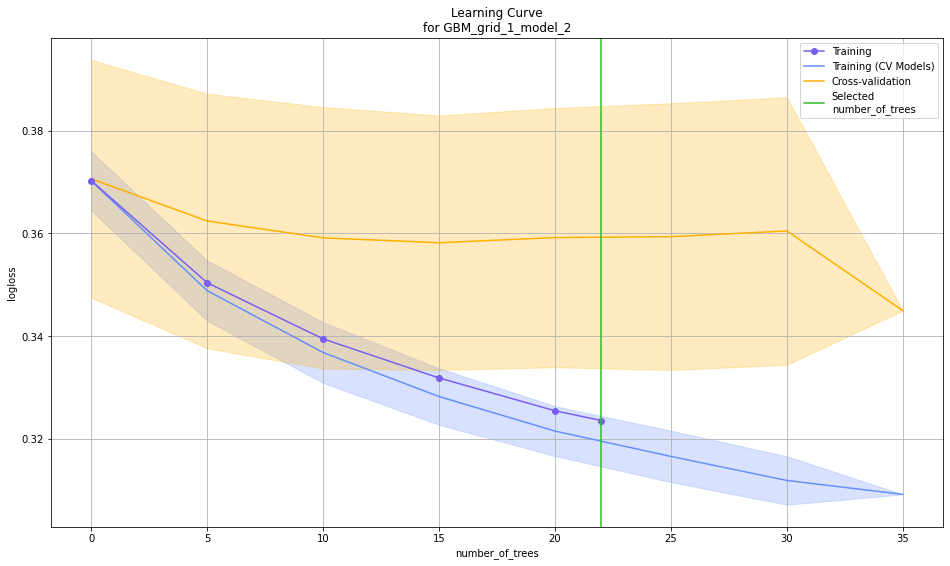

In [38]:
learning_curve_plot = gbm.learning_curve_plot()

Now we format and generate our own metrics

In [39]:
evaluation = {
        'Gini': '{:.6f}'.format(eval_metrics.gini()),
        'MSE': '{:.6f}'.format(eval_metrics.mse()),
        'RMSE': '{:.6f}'.format(eval_metrics.rmse()),
        'LogLoss': '{:.6f}'.format(eval_metrics.logloss()),
        'AUC': '{:.6f}'.format(eval_metrics.auc()),
        'AUCPR': '{:.6f}'.format(eval_metrics.aucpr()),
        'Accuracy': '{:.6f}'.format(eval_metrics.accuracy()[0][1]),
        'Mean Per-Class Error': '{:.6f}'.format(eval_metrics.mean_per_class_error()[0][1]),
        'F1 score': '{:.6f}'.format(eval_metrics.F1()[0][1]),
        'Precision': '{:.6f}'.format(eval_metrics.precision()[0][1]),
        'Sensitivity': '{:.6f}'.format(eval_metrics.sensitivity()[0][1]),
        'Specificity': '{:.6f}'.format(eval_metrics.specificity()[0][1]),
        'Recall': '{:.6f}'.format(eval_metrics.recall()[0][1])
    }

In [40]:
evaluation

{'Gini': '0.285552',
 'MSE': '0.087649',
 'RMSE': '0.296055',
 'LogLoss': '0.314910',
 'AUC': '0.642776',
 'AUCPR': '0.205619',
 'Accuracy': '0.900291',
 'Mean Per-Class Error': '0.390337',
 'F1 score': '0.264151',
 'Precision': '1.000000',
 'Sensitivity': '1.000000',
 'Specificity': '1.000000',
 'Recall': '1.000000'}